In [80]:
import pandas as pd
import numpy as np

In [81]:
# title budget genres country main_charactor director vote_average vote_count
df = pd.concat([pd.read_csv('data/movie_genres_data.csv'), pd.read_csv('data/movie_data_ID.csv')], axis=1)

In [82]:
# 로지스틱 회귀 모델(sigmoid) : weight초기화, dropout, ReLU, batch nomalization
# 결과 : 흥행성공, 흥행 실패, 전체영화 의 평균 정확도
# 1. 데이터셋 준비하기
df.drop(['title', 'genres', 'country', 'vote_score', 'vote_count'], axis=1, inplace=True)
df.vote_weight = df.vote_weight.apply(lambda x: 1 if x >= 11 else 0)

In [83]:
df.budget = df.budget / df.budget.max()
df.charactor = df.charactor / df.charactor.max()
df.director = df.director / df.director.max()

In [84]:
X = np.array(df)

In [85]:
# y_train : 흥행했는지(1) 안했는지(0)
from sklearn.model_selection import train_test_split
y = X[:, 22:]
X = X[:, :-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_val = X_test[:513]
y_val = y_test[:513]

In [86]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(4104, 22)
(4104, 1)
(513, 22)
(513, 1)
(1026, 22)
(1026, 1)


In [87]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [88]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=22))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [89]:
model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])

In [90]:
hist = model.fit(X_train, y_train, epochs=100, batch_size=32,
                validation_data=(X_val, y_val))

Epoch 1/100
129/129 [==============================] - 1s 4ms/step - loss: 0.2532 - accuracy: 0.4793 - val_loss: 0.2547 - val_accuracy: 0.4444
Epoch 2/100
129/129 [==============================] - 0s 3ms/step - loss: 0.2521 - accuracy: 0.4754 - val_loss: 0.2534 - val_accuracy: 0.4542
Epoch 3/100
129/129 [==============================] - 0s 3ms/step - loss: 0.2514 - accuracy: 0.4764 - val_loss: 0.2521 - val_accuracy: 0.4503
Epoch 4/100
129/129 [==============================] - 0s 3ms/step - loss: 0.2506 - accuracy: 0.4773 - val_loss: 0.2512 - val_accuracy: 0.4483
Epoch 5/100
129/129 [==============================] - 0s 3ms/step - loss: 0.2500 - accuracy: 0.4856 - val_loss: 0.2505 - val_accuracy: 0.4678
Epoch 6/100
129/129 [==============================] - 0s 3ms/step - loss: 0.2495 - accuracy: 0.5010 - val_loss: 0.2501 - val_accuracy: 0.4815
Epoch 7/100
129/129 [==============================] - 0s 3ms/step - loss: 0.2490 - accuracy: 0.5266 - val_loss: 0.2497 - val_accuracy: 0.5088

In [91]:
loss_and_metrics = model.evaluate(X_test, y_test, batch_size=32)
print('손실 :', loss_and_metrics[0])
print('정확도 :', loss_and_metrics[1] * 100, '%')
print("-" * 20)

33/33 [==============================] - 0s 2ms/step - loss: 0.2047 - accuracy: 0.6784
손실 : 0.2046906054019928
정확도 : 67.83625483512878 %
--------------------


In [94]:
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams.update({'text.color': "black",
                    'axes.labelcolor': "white",
                     'xtick.color': "white",
                     'ytick.color': "white"
                     })

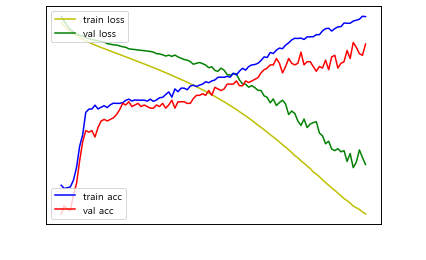

In [95]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'g', label='val loss')

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'r', label='val acc')

loss_ax.set_xlabel('epoch')

loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [96]:
yhat = model.predict(X_test)
for i in range(10):
    print(1 if yhat[i] > 0.5 else 0, end=" ")
print()
for i in y_test[:10]:
    print(int(*i), end=" ")

33/33 [==============================] - 0s 2ms/step
1 1 0 0 1 1 1 0 0 1 
1 0 0 0 0 0 1 1 0 0 